#  Notebook by Abhinav Darsi - [AB]

# Acknowledgments
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.https://appen.com/resources/datasets/

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

### Data format 
Each sample in the train and test set has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

### Files

* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format 

### Features

* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

### Problem Statement 

* To  predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# Tweets Real or Not - A Classification Problem 
<br>
<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTbmtImbdYE8HEt_GzzxuWvTAXcNTzdk-vC0q3q5wtzbWniXvQG' alt='twitter' style='float:left' width=100%>
<div style='clear:both'></div>
<hr>

This kernel will be devided into the following parts<br>
<ol>
    <li><b>Data Exploration</b></li>
    <li><b>Data Preprocessing</b></li>
    <li><b>NLP Techniques</b></li>
    <li><b>Feature Extraction</b></li>
    <li><b>Data Visualization</b></li>
    <li><b>Vectorization and Standardization</b></li>
    <li><b>Models Bulding</b></li>
    <li><b>Models evaluation</b></li>
</ol>


###  Importing libraries and loading the data.

In [125]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
plt.style.use('seaborn-dark')

import re
import string 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

print("Important libraries loaded successfully")

Important libraries loaded successfully


# 1. Data Exploration

In [7]:
df_train = pd.read_csv("train.csv")
print('There are {} Rows and {} Columns in Train Dataset'.format(df_train.shape[0],df_train.shape[1]))
df_train.head()

There are 7613 Rows and 5 Columns in Train Dataset


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


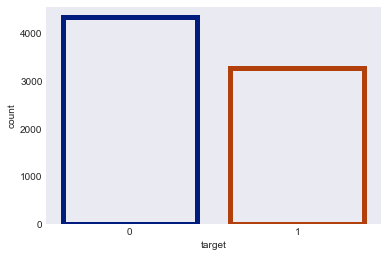

In [13]:
ax = sns.countplot(x="target", data= df_train,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))

It can be seen from the countplot that there are more tweets that are considered as not a disaster.

As we see in train table we have some missing values. So let's deal with it

# 2. Data Preprocessing
Data Preprocessing one of important steps in any data science or machine learning project so let's start.
## 2.1 Missing Data

In [9]:
#Get total count of data including missing data
total = df_train.isnull().sum().sort_values(ascending=False)

#Get percent of missing data relevant to all data
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(df_train.shape[1])

,Total,Percent
location,2533,0.332720
keyword,61,0.008013
target,0,0.000000
text,0,0.000000
id,0,0.000000


As we see in above table almost 33% of **location** column is missing and very littel percentage of **keyword** column is missing.<br>

## 2.2 How to Handle Missing Data ?
One of the most common problems we have faced in Data Analysis is handling the missing values.<br>

I love put this image in my kernels because it give a roadmap to handle **missing data** 
<img src='https://miro.medium.com/max/1528/1*_RA3mCS30Pr0vUxbp25Yxw.png' width="550px" style='float:left;'>
<div style='clear:both'></div>
<br>

In **Deletion** I will use **Deleting Columns** technique. Now we will drop **location** and **keyword** columns.

In [11]:
df_train = df_train.drop(['location','keyword'], axis=1)
print("location and keyword columns droped successfully")

location and keyword columns droped successfully


We all know that **id** column isn't important to us, so we will drop it

In [12]:
df_train = df_train.drop('id', axis=1)
print("id column droped successfully")

id column droped successfully


# 3. Basic NLP Techniques
<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT6TkPpD8nWsbTVa9ExwfCQUnFmzkNE8zjZJ3uXSaBVd09ErhvZ' alt='text preprocessing' style='float:left' width=50% >
<div style='clear:both'></div>
<hr>
Before starting text preprocess steps we must we must know two terms **Corpus and Bag of word.**<br>

**Corpus :** Is a large and structured set of texts, We can consider it as simplified version of our text data that contain clean and benefit data.<br>

**Bag of word :** In practice, the Bag-of-words model is mainly used as a tool of feature generation. After transforming the text into a "bag of words", we can calculate various measures to characterize the text [wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model)<br>

Now we will do the following steps to preprocess our text data
<ol>
    <li><b>Remove unwanted words</b></li>
    <li><b>Transform words to lowercase</b></li>
    <li><b>Remove stopwords</b></li>
    <li><b>Stemming words</b></li>
    <li><b>Create sparse matrix ( Bag of words )</b></li>
</ol>  
Now let's deal with our **text** column by exploar it.

## 3.1 Remove unwanted words
As we see our **text** column contain unwanted words as **#, =>, numbers, or ... etc** these letters will not be useful in our problem so we will get only pure text without any markings or numbers.<br>

We will do it by **specify** our pattern using **re** library.

## 3.2 Transform words to lowercase
We must transform words to lowercase because each letter has own **ASCII Code** that represent text in computers, Uppercase letter has different ASCII Code than same letter in lowercase format. **so that** 'A' letter differ from 'a' letter in computer.

## 3.3 Remove stopwords
**Stop words :** are generally the most common words in a language, so we will remove it to prevent misleading problem in our model.

## 3.4 Stemming words
**stemming :** is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form [wikipedia](https://en.wikipedia.org/wiki/Stemming)<br>
We use stemming to reduce **bag of words** dimensionality.

In [15]:
corpus  = []
pstem = PorterStemmer()
for i in range(df_train['text'].shape[0]):
    #Remove unwanted words
    tweet = re.sub("[^a-zA-Z]", ' ', df_train['text'][i])
    #Transform words to lowercase
    tweet = tweet.lower()
    tweet = tweet.split()
    #Remove stopwords then Stemming it
    tweet = [pstem.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    #Append cleaned tweet to corpus
    corpus.append(tweet)
    
print("Corpus created successfully")    

Corpus created successfully


**Let's explore corpus, and discover the difference between raw and clean text data**

In [18]:
print(pd.DataFrame(corpus)[0].head(10))

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3          peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
5    rockyfir updat california hwi close direct due...
6    flood disast heavi rain caus flash flood stree...
7                               top hill see fire wood
8               emerg evacu happen build across street
9                             afraid tornado come area
Name: 0, dtype: object


In [26]:
raw_Tex_Data_1 = df_train['text']
clean_Tex_Data = pd.DataFrame(corpus, columns=['text_after_cleaning'])
raw_Tex_Data_2 = df_train['target']

frames = [raw_Tex_Data_1, clean_Tex_Data,raw_Tex_Data_2]
result = pd.concat(frames, axis=1, sort=False)
result

,text,text_after_cleaning,target
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us,1
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada,1
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...,1
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california,1
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...,1
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,two giant crane hold bridg collaps nearbi home...,1
7609,@aria_ahrary @TheTawniest The out of control w...,aria ahrari thetawniest control wild fire cali...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,utc km volcano hawaii http co zdtoyd ebj,1
7611,Police investigating after an e-bike collided ...,polic investig e bike collid car littl portug ...,1


# 4. Feature Extratction
Now we will extract following features  from the cleaned data
<ol>
    <li><b>Total number of words in a cleaned tweet</b></li>
    <li><b>Average word length of a cleaned tweet</b></li>
    <li><b>Total characters ina cleaned tweet</b></li>
    <li><b>NUmber of Unique words in a cleaned tweet</b></li>
    <li><b>stopword_count</b></li>
    <li><b>Url count in an uncleaned tweet</b></li>
    <li><b>Total Hashtag count in an uncleaned tweet</b></li>
    <li><b>Punctuation count in a an uncleaned tweet</b></li>

In [30]:
result['Clean_text_word_count'] = result['text_after_cleaning'].apply(lambda x : len(x.split()))

#add unique word count
result['Clean_unique_words'] = result['text_after_cleaning'].apply(lambda x: len(set(x.split())))

#add stopword count
s = stopwords.words('english') 
result['stopword_count'] = result['text'].apply(lambda x: len([i for i in x.lower().split() if i in s]))

#add url count
result['url_count'] = result['text'].apply(lambda x: len([i for i in x.lower().split() if 'http' in i or 'https' in i]))

#add mention count
result['mention_count'] = result['text'].apply(lambda x: len([i for i in str(x) if i == '@']))

#add hashtag count
result['hashtag_count'] = result['text'].apply(lambda x: len([i for i in str(x) if i == '#']))

#add punctuation count
result['punctuation_count'] = result['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))


In [44]:
#create column for the number of characters in a tweet
result['Clean_text_character count'] = result['text_after_cleaning'].apply(lambda x: len(x))

#define function to find average word length 
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#broadcast to text column
result['Clean_average_word_length'] = result['text_after_cleaning'].apply(average_word_length)

In [45]:
result.head()

,text,text_after_cleaning,target,Clean_text_word_count,Clean_unique_words,stopword_count,url_count,mention_count,hashtag_count,punctuation_count,Clean_text_character count,Clean_average_word_length
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us,1,7,7,6,0,0,1,1,41,5.000000
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada,1,7,7,0,0,0,0,1,36,4.285714
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...,1,11,9,11,0,0,0,3,69,5.363636
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california,1,6,6,1,0,0,1,2,43,6.333333
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...,1,9,9,7,0,0,2,2,52,4.888889


# 5. Data Visualization 

In statistics, **kernel density estimation (KDE)** is a non-parametric way to estimate the probability density function of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample. In some fields such as signal processing and econometrics it is also termed the Parzen–Rosenblatt window method, after Emanuel Parzen and Murray Rosenblatt, who are usually credited with independently creating it in its current form.One of the famous applications of kernel density estimation is in estimating the class-conditional marginal densities of data when using a naive Bayes classifier, which can improve its prediction accuracy dramatically

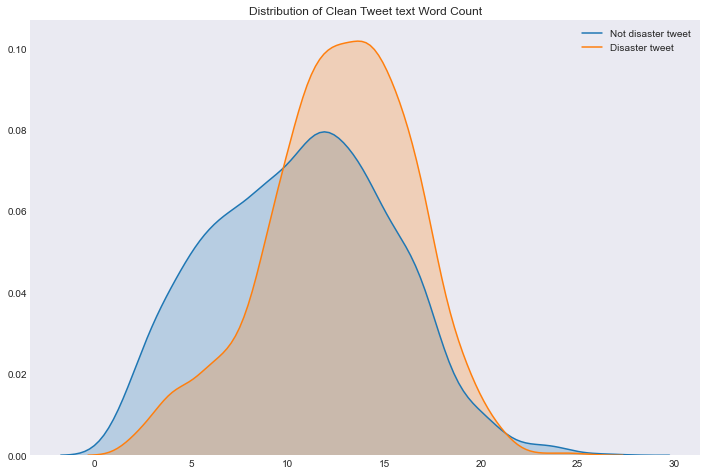

In [66]:
# Clean text Word Count

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (12, 8))
#create graphs
sns.kdeplot(result['Clean_text_word_count'][result['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(result['Clean_text_word_count'][result['target'] == 1], shade = True, label = 'Disaster tweet')
#set title and plot
plt.title('Distribution of Clean Tweet text Word Count')
plt.show()

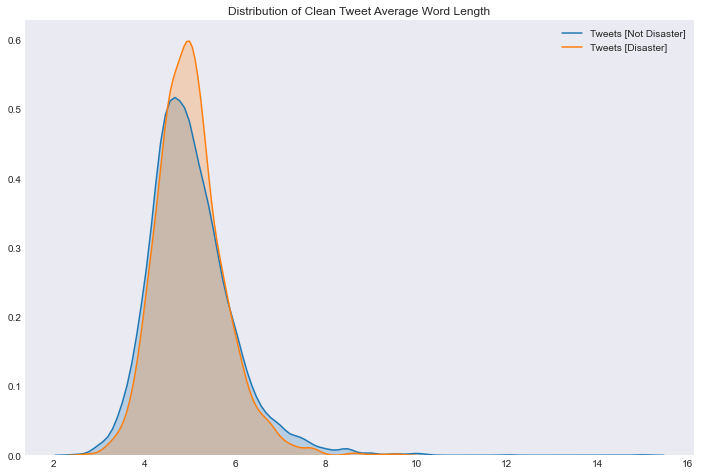

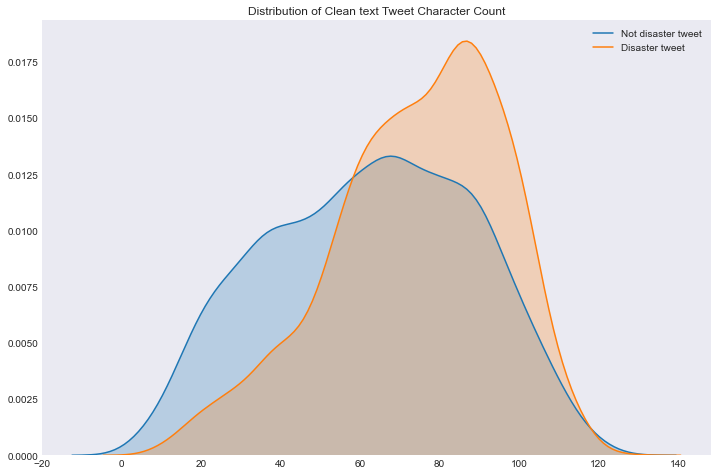

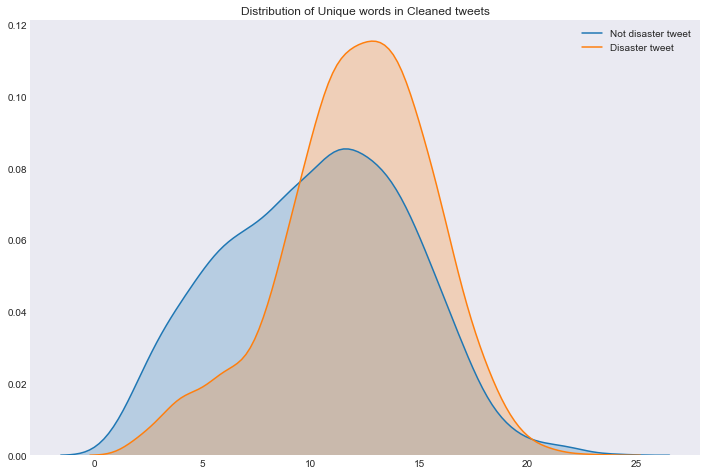

In [65]:
# Clean text  Average word length Count
fig, ax = plt.subplots(figsize = (12, 8))
sns.kdeplot(result['Clean_average_word_length'][result['target'] == 0], shade = True, label = 'Tweets [Not Disaster]')
sns.kdeplot(result['Clean_average_word_length'][result['target'] == 1], shade = True, label = 'Tweets [Disaster]')
plt.title('Distribution of Clean Tweet Average Word Length')
plt.show()

# Clean text  Charecter Count
fig, ax = plt.subplots(figsize = (12, 8))
sns.kdeplot(result['Clean_text_character count'][result['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(result['Clean_text_character count'][result['target'] == 1], shade = True, label = 'Disaster tweet')
plt.title('Distribution of Clean text Tweet Character Count')
plt.show()

# Clean text Unique words count
fig, ax = plt.subplots(figsize = (12, 8))
graph2 = sns.kdeplot(result['Clean_unique_words'][result['target'] == 0], shade = True, label = 'Not disaster tweet')
graph2 = sns.kdeplot(result['Clean_unique_words'][result['target'] == 1], shade = True, label = 'Disaster tweet')
graph2.set_title('Distribution of Unique words in Cleaned tweets')
plt.show()


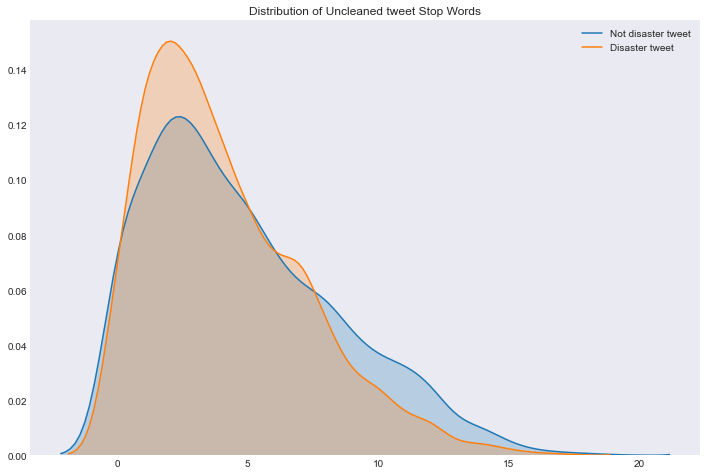

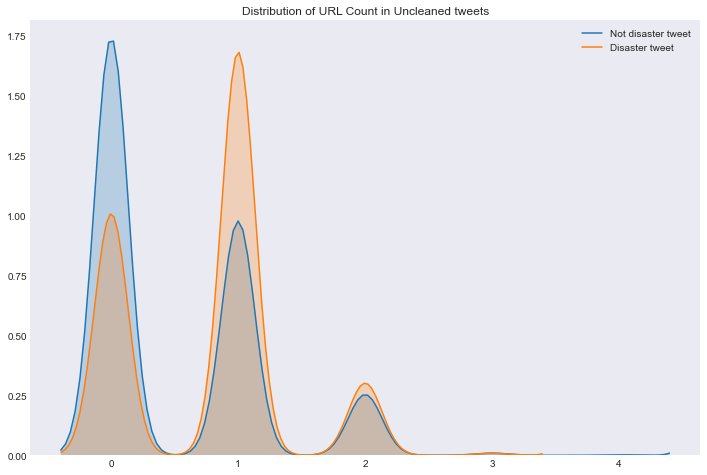

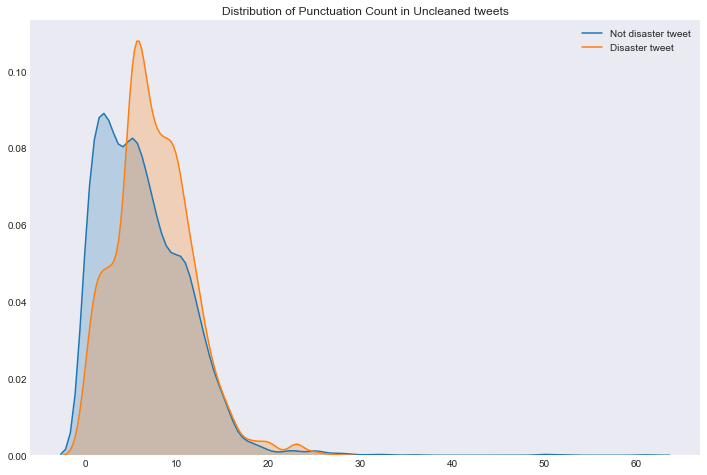

In [64]:
# Unclean text Stop Word Count
fig, ax = plt.subplots(figsize = (12, 8))
graph1 = sns.kdeplot(result['stopword_count'][result['target'] == 0], shade = True, label = 'Not disaster tweet')
graph1 = sns.kdeplot(result['stopword_count'][result['target'] == 1], shade = True, label = 'Disaster tweet')
graph1.set_title('Distribution of Uncleaned tweet Stop Words')
plt.show()

# Url count
fig, ax = plt.subplots(figsize = (12, 8))
graph3 = sns.kdeplot(result['url_count'][result['target'] == 0], shade = True, label = 'Not disaster tweet')
graph3 = sns.kdeplot(result['url_count'][result['target'] == 1], shade = True, label = 'Disaster tweet')
graph3.set_title('Distribution of URL Count in Uncleaned tweets')
plt.show()

# Punctuation Count 
fig, ax = plt.subplots(figsize = (12, 8))
graph4 = sns.kdeplot(result['punctuation_count'][result['target'] == 0], shade = True, label = 'Not disaster tweet')
graph4 = sns.kdeplot(result['punctuation_count'][result['target'] == 1], shade = True, label = 'Disaster tweet')
graph4.set_title('Distribution of Punctuation Count in Uncleaned tweets')
plt.show()

# 6. Vectorization  

In [81]:
#Create our dictionary 
uniqueWordFrequents = {}
for tweet in corpus:
    for word in tweet.split():
        if(word in uniqueWordFrequents.keys()):
            uniqueWordFrequents[word] += 1
        else:
            uniqueWordFrequents[word] = 1
            
#Convert dictionary to dataFrame
uniqueWordFrequents = pd.DataFrame.from_dict(uniqueWordFrequents,orient='index',columns=['Word Frequent'])
uniqueWordFrequents.sort_values(by=['Word Frequent'], inplace=True, ascending=False)
uniqueWordFrequents.head(10)

,Word Frequent
co,4746
http,4721
like,411
fire,363
amp,344
get,311
bomb,239
new,228
via,220
u,216


In [82]:
uniqueWordFrequents['Word Frequent'].unique()

array([4746, 4721,  411,  363,  344,  311,  239,  228,  220,  216,  213,
        210,  209,  201,  183,  181,  180,  178,  175,  169,  166,  164,
        162,  156,  155,  153,  151,  145,  144,  143,  137,  133,  132,
        131,  130,  129,  128,  125,  124,  123,  122,  121,  120,  119,
        118,  117,  116,  114,  111,  110,  109,  108,  106,  105,  104,
        103,  102,  101,  100,   99,   98,   97,   96,   95,   94,   93,
         91,   90,   89,   88,   87,   86,   84,   83,   82,   79,   78,
         77,   76,   75,   74,   73,   72,   71,   70,   69,   68,   67,
         66,   65,   64,   63,   62,   61,   60,   59,   58,   57,   56,
         55,   54,   53,   52,   51,   50,   49,   48,   47,   46,   45,
         44,   43,   42,   41,   40,   39,   38,   37,   36,   35,   34,
         33,   32,   31,   30,   29,   28,   27,   26,   25,   24,   23,
         22,   21,   20,   19,   18,   17,   16,   15,   14,   13,   12,
         11,   10,    9,    8,    7,    6,    5,   

As we see some words repeated a lot and others repeated less, so we will get only words that repeated more than or equal 20 once.
There some words that repeated so little in our tweets, so we must remove these words from our **Bag of words** to decrease dimensionality as possible.<br>

We will do it by create dictionary where **key** refer to **word** and **value** refer to **word frequents in all tweets**.

In [83]:
uniqueWordFrequents = uniqueWordFrequents[uniqueWordFrequents['Word Frequent'] >= 20]
print(uniqueWordFrequents.shape)
uniqueWordFrequents

(787, 1)


,Word Frequent
co,4746
http,4721
like,411
fire,363
amp,344
...,...
cnn,20
gem,20
captur,20
arriv,20


### Create sparse matrix ( Bag of words )
**Bag of word** contain only unique words in corpus.

In [84]:
counVec = CountVectorizer(max_features = uniqueWordFrequents.shape[0])
bagOfWords = counVec.fit_transform(corpus).toarray()

In [93]:
bagOfWords.shape

(7613, 787)

In [104]:
Vec_Tex_Data = pd.DataFrame(bagOfWords)
frames_1 = [result, Vec_Tex_Data]
result_final = pd.concat(frames_1, axis=1, sort=False)


In [107]:
result_final 

,text,text_after_cleaning,target,Clean_text_word_count,Clean_unique_words,stopword_count,url_count,mention_count,hashtag_count,punctuation_count,...,777,778,779,780,781,782,783,784,785,786
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us,1,7,7,6,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada,1,7,7,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...,1,11,9,11,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california,1,6,6,1,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...,1,9,9,7,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0


In [108]:
result_final = result_final.drop(['text','text_after_cleaning'], axis=1)
print("text and text_after_cleaning columns droped successfully")

text and text_after_cleaning columns droped successfully


In [132]:
result_final.head()

,target,Clean_text_word_count,Clean_unique_words,stopword_count,url_count,mention_count,hashtag_count,punctuation_count,Clean_text_character count,Clean_average_word_length,...,777,778,779,780,781,782,783,784,785,786
0,1,7,7,6,0,0,1,1,41,5.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,7,7,0,0,0,0,1,36,4.285714,...,0,0,0,0,0,0,0,0,0,0
2,1,11,9,11,0,0,0,3,69,5.363636,...,0,0,0,0,0,0,0,0,0,0
3,1,6,6,1,0,0,1,2,43,6.333333,...,0,0,0,0,0,0,0,0,0,0
4,1,9,9,7,0,0,2,2,52,4.888889,...,0,0,0,0,0,0,0,0,0,0


# 7. Models Bulding
Now we will build our models, we will use following models
* Decision Tree Model
* Gradient Boosting Model
* K - Nearest Neighbors Model
* Logistic Regression Model
* Stochastic Gradient Descent Model
* Support Vector Machine Model
* Bernoulli Naive Bayes Model
* Gaussian Naive Bayes Model
* Multinomial Naive Bayes Model
* Voting Classifier Model

But before using it we will split our data to train and test set first.

In [111]:
X = result_final.drop(['target'], axis=1)
y = result_final['target']
print("X shape = ",X.shape)
print("y shape = ",y.shape)

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.20, random_state=55, shuffle =True)
print('Data splitting successfully')

X shape =  (7613, 796)
y shape =  (7613,)
Data splitting successfully


## 7.1 Decision Tree Model

In [112]:
decisionTreeModel = DecisionTreeClassifier(criterion= 'entropy',max_depth = None, splitter='best', random_state=55)

decisionTreeModel.fit(X_train,y_train)

print("Decision Tree Classifier model run successfully")

Decision Tree Classifier model run successfully


## 7.2 Gradient Boosting Model

In [113]:
gradientBoostingModel = GradientBoostingClassifier(loss = 'deviance',learning_rate = 0.01,n_estimators = 100, max_depth = 30,
                                                   random_state=55)

gradientBoostingModel.fit(X_train,y_train)

print("Gradient Boosting Classifier model run successfully")

Gradient Boosting Classifier model run successfully


## 7.3 K - Nearest Neighbors Model

In [114]:
KNeighborsModel = KNeighborsClassifier(n_neighbors = 7,
                                       weights = 'distance',
                                      algorithm = 'brute')

KNeighborsModel.fit(X_train,y_train)

print("KNeighbors Classifier model run successfully")

KNeighbors Classifier model run successfully


## 7.4 Logistic Regression Model

In [115]:
LogisticRegression = LogisticRegression(penalty='l2', 
                                        solver='saga', 
                                        random_state = 55)  

LogisticRegression.fit(X_train,y_train)

print("LogisticRegression Classifier model run successfully")

LogisticRegression Classifier model run successfully


## 4.5 Stochastic Gradient Descent Model

In [116]:
SGDClassifier = SGDClassifier(loss = 'hinge', penalty = 'l1', learning_rate = 'optimal', random_state = 55, max_iter=100)

SGDClassifier.fit(X_train,y_train)

print("SGDClassifier Classifier model run successfully")

SGDClassifier Classifier model run successfully


## 7.6 Support Vector Machine Model

In [117]:
SVClassifier = SVC(kernel= 'linear', degree=3, max_iter=10000, C=2, random_state = 55)
SVClassifier.fit(X_train,y_train)
print("SVClassifier model run successfully")

SVClassifier model run successfully


## 7.7 Bernoulli Naive Bayes Model

In [120]:
bernoulliNBModel = BernoulliNB(alpha=0.1)
bernoulliNBModel.fit(X_train,y_train)

print("BernoulliNB model run successfully")

BernoulliNB model run successfully


## 7.8 Gaussian Naive Bayes Model

In [118]:
gaussianNBModel = GaussianNB()
gaussianNBModel.fit(X_train,y_train)
print("GaussianNB model run successfully")

GaussianNB model run successfully


## 7.9 Multinomial Naive Bayes Model

In [122]:
multinomialNBModel = MultinomialNB(alpha=0.1)
multinomialNBModel.fit(X_train,y_train)

print("MultinomialNB model run successfully")

MultinomialNB model run successfully


## 7.10 Voting Classifier Model

In [123]:
modelNames = [('LogisticRegression',LogisticRegression),
               ('SGDClassifier',SGDClassifier),
               ('SVClassifier',SVClassifier),
               ('bernoulliNBModel',bernoulliNBModel),
               ('multinomialNBModel',multinomialNBModel)]

votingClassifier = VotingClassifier(voting = 'hard',estimators= modelNames)
votingClassifier.fit(X_train,y_train)
print("votingClassifier model run successfully")

votingClassifier model run successfully


# 8. Models evaluation

Now we will evaluate our model using **f1_score**. 

In [124]:
#evaluation Details
models = [decisionTreeModel, gradientBoostingModel, KNeighborsModel, LogisticRegression, 
          SGDClassifier, SVClassifier, bernoulliNBModel, gaussianNBModel, multinomialNBModel, votingClassifier]

for model in models:
    print(type(model).__name__,' Train Score is   : ' ,model.score(X_train, y_train))
    print(type(model).__name__,' Test Score is    : ' ,model.score(X_test, y_test))
    
    y_pred = model.predict(X_test)
    print(type(model).__name__,' F1 Score is      : ' ,f1_score(y_test,y_pred))
    print('--------------------------------------------------------------------------')

DecisionTreeClassifier  Train Score is   :  0.9949096880131363
DecisionTreeClassifier  Test Score is    :  0.7058437294812869
DecisionTreeClassifier  F1 Score is      :  0.6345840130505709
--------------------------------------------------------------------------
GradientBoostingClassifier  Train Score is   :  0.9376026272577996
GradientBoostingClassifier  Test Score is    :  0.7235718975705844
GradientBoostingClassifier  F1 Score is      :  0.6447257383966245
--------------------------------------------------------------------------
KNeighborsClassifier  Train Score is   :  0.9949096880131363
KNeighborsClassifier  Test Score is    :  0.6539724228496389
KNeighborsClassifier  F1 Score is      :  0.5507246376811595
--------------------------------------------------------------------------
LogisticRegression  Train Score is   :  0.7558292282430213
LogisticRegression  Test Score is    :  0.7399868680236376
LogisticRegression  F1 Score is      :  0.6532399299474606
-------------------------